<a href="https://colab.research.google.com/github/mateusz-wozny/IMO/blob/main/GreedyCycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [39]:
import pandas as pd
ver_data = np.array(pd.read_csv('kroA100.txt', sep=' ', header=None).iloc[:, 1:])

In [40]:
def createDistanceMatrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]

  return np.array(outputMatrix)

In [11]:
def chooseNearestVertex(matrix, used_vertexes, node):
  return np.argmin([matrix[node][i] if i not in used_vertexes and i != node else float('inf') for i in range(0, len(matrix[node]))])


In [12]:
def calculateCycleLength(matrix, vertexes):
  length = 0
  for graph in vertexes:
    length += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])

#   print(length)
  return length

In [41]:
def find_nearest(dist, lista, nieodw):
    df = dist[:, lista][nieodw, :]
    ind, minim = np.unravel_index(df.argmin(), df.shape)
    return nieodw[ind], lista[minim]
def nearest_neighbor(dist_mat, start):
    end = np.argmax(dist_mat[start, :])
    nieodw = list(range(dist_mat.shape[0]))
    nieodw.remove(start)
    nieodw.remove(end)
    list1 = [start]
    list2 = [end]
    while len(nieodw) != 0:
        ind, minim = find_nearest(dist_mat, list1, nieodw)
        list1.insert(list1.index(minim) + 1, ind)
        nieodw.remove(ind)
        ind, minim = find_nearest(dist_mat, list2, nieodw)
        list2.insert(list2.index(minim) + 1, ind)
        nieodw.remove(ind)
    list1.append(start)
    list2.append(end)

    return [list1, list2]

In [13]:
def greedyCycle(matrix, start_node):
    #Starting node 2
    start_node_2 = np.argmax(matrix[start_node])

    #Choosing nearest vertex for cycles
    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    #Creating cycles
    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    #Calculating cycles
    while len(cycles[0])+len(cycles[1]) != len(matrix):
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]

        z = np.inf
        x = np.inf
        c = np.inf

        for i in range(len(visited)):
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), visited[i])
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                if value < z:
                    z = value
                    x = j + 1
                    c = nearest

        if len(cycles[0]) <= len(cycles[1]):
            cycles[0] = np.insert(cycles[0], x, c)
        else:
            cycles[1] = np.insert(cycles[1], x, c)

    return cycles
                

     

In [28]:
def draw_plot(vertices, visited, length):
  for graph in visited:
    x = vertices[graph, 0]
    y = vertices[graph,1]
    plt.plot(x, y)
  plt.suptitle(f'score: {int(length)}')
  plt.show()

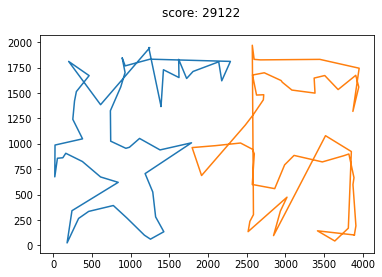

In [38]:
distance_matrix = createDistanceMatrix(ver_data)
start_node = random.randint(0, len(distance_matrix) - 1)
# start_node = 1

vertexes = nearest_neighbor(distance_matrix, start_node)
length = calculateCycleLength(distance_matrix, vertexes)
draw_plot(ver_data, vertexes, length)
